<a href="https://colab.research.google.com/github/jofmorenore/TS_Climatic/blob/main/R%5CHierarchical_clustering_of_spatially_correlated_fd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [Hierarchical clustering of spatially correlated data]( https://doi.org/10.1111/j.1467-9574.2012.00522.x)

# Configuración del entorno R en colab

In [31]:
# https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str
!pip install rpy2==3.5.1

In [32]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [33]:
%%R
getwd()

[1] "/content"


In [34]:
%%R
sessionInfo()

R version 4.5.2 (2025-10-31)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] splines   tools     stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] cluster_2.1.8.1  units_1.0-0      dplyr_1.1.4      geofd_2.0       
 [5] geoR_1.9-6       ggdendro_0.2.0   ggrepel_0.9.6    fda_6.3.0       
 [9] deSolve_1.40 

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Librerías

In [36]:
%%R
#if("geofd" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geofd"))}
#library(geofd)
#library(remotes)
remotes::install_github("cran/geofd") # fit.tracevariog

  Use `force = TRUE` to force installation



In [37]:
%%R
if("sf" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sf"))}
library(sf)

In [38]:
%%R
if("sp" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("sp"))}
library(sp) # CRS

In [39]:
%%R
if("factoextra" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("factoextra"))}
library(factoextra)

In [40]:
%%R
if("maps" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("maps"))}
library(maps)

In [41]:
%%R
if("fda" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("fda"))}
library(fda) # fRegress

In [42]:
%%R
if("ggrepel" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("ggrepel"))}
library(ggrepel) # avoid overlap labels in map

In [43]:
%%R
if("ggdendro" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("ggdendro"))}
library(ggdendro) # fRegress

In [44]:
%%R
if("geoR" %in% row.names(installed.packages())==FALSE){suppressMessages(install.packages("geoR"))}
library(geoR) # cov.spatial

In [45]:
%%R
library(sf)
library(sp)
library(fda)
library(geofd)
library(maps)
library(dplyr)
library(ggplot2)
library(ggrepel) # avoid overlap labels in map
library(ggdendro)
library(units)
library(cluster)
library(geoR)

# “Canadian temperature” data (Ramsey & Silverman)

In [46]:
%%R
#canada <- map_data("world", region = "Canada")
canada <- map("world", "Canada", fill = TRUE, plot = FALSE)
data(CanadianWeather, package="fda")
str(CanadianWeather, max.level = 1)

List of 8
 $ dailyAv      : num [1:365, 1:35, 1:3] -3.6 -3.1 -3.4 -4.4 -2.9 -4.5 -5.5 -3.1 -4 -5 ...
  ..- attr(*, "dimnames")=List of 3
 $ place        : chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ province     : Named chr [1:35] "Newfoundland" "Nova Scotia" "Nova Scotia" "Nova Scotia" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ coordinates  : num [1:35, 1:2] 47.3 44.4 46.1 43.5 42.5 ...
  ..- attr(*, "dimnames")=List of 2
 $ region       : Named chr [1:35] "Atlantic" "Atlantic" "Atlantic" "Atlantic" ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...
 $ monthlyTemp  : num [1:12, 1:35] -4.65 -5.33 -2.53 1.26 5.79 ...
  ..- attr(*, "dimnames")=List of 2
 $ monthlyPrecip: num [1:12, 1:35] 4.65 4.74 4.24 3.62 3.25 ...
  ..- attr(*, "dimnames")=List of 2
 $ geogindex    : Named num [1:35] 24 9 25 34 4 8 22 1 2 19 ...
  ..- attr(*, "names")= chr [1:35] "St. Johns" "Halifax" "Sydney" "Yarmouth" ...


In [47]:
%%R
print(class(CanadianWeather$coordinates))
head(CanadianWeather$coordinates)

[1] "matrix" "array" 
            N.latitude W.longitude
St. Johns        47.34       52.43
Halifax          44.39       63.36
Sydney           46.09       60.11
Yarmouth         43.50       66.07
Charlottvl       42.48       80.25
Fredericton      45.58       66.39


# Fig. 5. Averages (over 30 years) of mean daily temperature curves (down) recorded at 35 Canadian weather stations (up).

In [48]:
%%R
Canada_weather = data.frame(place = CanadianWeather$place,
                            lat = CanadianWeather$coordinates[,1],
                            lon = -CanadianWeather$coordinates[,2]) %>%
  st_as_sf(coords=c("lon", "lat"), crs =4326)

**Observación: la sttn 'Charlottvl' en el paper aparece más al este (al lado de 'Fredericton')**

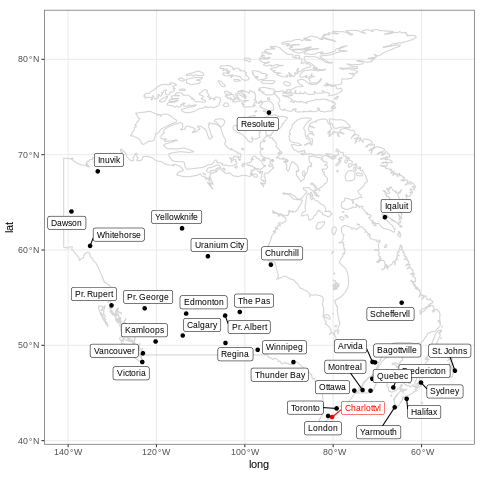

In [49]:
%%R
canada <- map("world", "Canada", fill = TRUE, plot = FALSE)
# Graficar los bordes de Canadá
ggplot() +
  geom_polygon(data = canada, aes(x = long, y = lat, group = group),
               color = "lightgray", fill = NA) +
  geom_sf(data = Canada_weather,
          col = ifelse(Canada_weather$place == "Charlottvl", "red", "black")) +
  geom_label_repel(data = Canada_weather,
                   aes(label = place, colour = flag, geometry = geometry),
                   stat = "sf_coordinates",  # Extract coordinates from sf geometry
                   size = 3,
                   color = ifelse(Canada_weather$place == "Charlottvl", "red", "black"))+
  theme_bw()

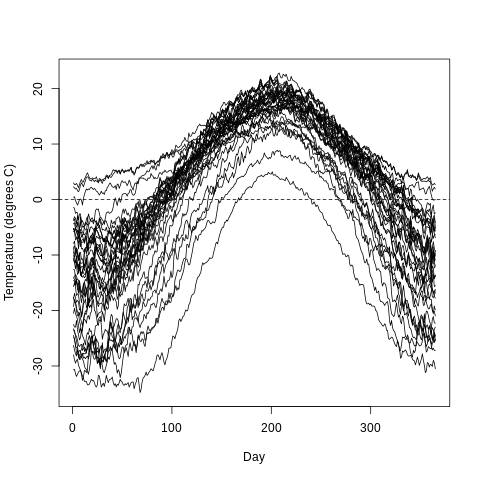

In [50]:
%%R
#jpeg("Fig5b.jpg", width = 900, height = 900)
plot(CanadianWeather$dailyAv[,1,'Temperature.C'], type = 'l', ylab = 'Temperature (degrees C)', xlab = 'Day', ylim =c(-35,23))
apply(CanadianWeather$dailyAv[,-1,'Temperature.C'], 2, function(x) lines(x))
abline(h=0, lty=2)
#dev.off()

# Smooth the observed data using [geodf](https://cran.r-project.org/web/packages/geofd/geofd.pdf)

A Fourier basis with 65 functions is used to smooth the discrete temperature values observed at each weather station

[1] "done"


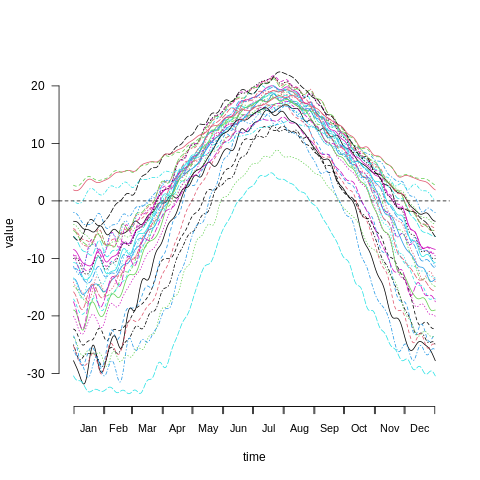

In [51]:
%%R
### functional response with vector explanatory variables
daybasis65 <- create.fourier.basis(rangeval=c(0, 365), nbasis=65, period = 365,
                                   axes=list('axesIntervals'))
Temp.fd <- with(CanadianWeather, smooth.basisPar(day.5,
                                                 dailyAv[,,'Temperature.C'], daybasis65)$fd)

plot(Temp.fd)

# Remove the spatial trend

Consider the functional linear model (Eq 12)

$$ X_i(t) = \hat{\alpha}(t) + \hat{\alpha}_1(t) {Longitude}_i + \hat{\alpha}_2(t) {Latitude}_i + e_i(t) $$

+ Modelo de regresión función con las coordenadas en grados decimales

In [52]:
%%R
# coords_: data frame con coordenadas para regresión funcional
coords_ <- data.frame(W.longitude = -CanadianWeather$coordinates[, "W.longitude"],
                      N.latitude = CanadianWeather$coordinates[, "N.latitude"])
head(coords_)

            W.longitude N.latitude
St. Johns        -52.43      47.34
Halifax          -63.36      44.39
Sydney           -60.11      46.09
Yarmouth         -66.07      43.50
Charlottvl       -80.25      42.48
Fredericton      -66.39      45.58


In [53]:
%%R
## (Cap 10) Ramsay, J., Hooker, G., Graves, S. (2009). Functional Linear Models for Scalar Responses.
##  In: Functional Data Analysis with R and MATLAB. Use R. Springer, New York, NY. https://doi.org/10.1007/978-0-387-98185-7_9
# xfdlist: list of independent variables
xfdList <- list(const = rep(1, 35),
                N.latitude = coords_$N.latitude,
                W.longitude = coords_$W.longitude)

# betalist : functional parameter objects (class fdPar) defining the regression functions to be estimated.
alphabasis <- create.constant.basis(c(0, 365),65)
betabasis = create.fourier.basis(c(0, 365), 65)
betafdPar = fdPar(betabasis)
betaList = vector("list",3)
betaList[[1]] = fdPar(alphabasis)
for (j in 1:2) betaList[[j+1]] = betafdPar

In [54]:
%%R
# fRegress: regresión con respuesta funcional y covariables escalares
TempRgn.f <- fRegress(Temp.fd ~ N.latitude + W.longitude,
                      data = coords_,
                      xfdlist = xfdList,
                      betalist = betaList)

fdobj.res = Temp.fd-TempRgn.f$yhatfdobj
summary(TempRgn.f)

               Length Class  Mode   
yfdobj             3  fd     list   
xfdlist            3  -none- list   
betalist           3  -none- list   
betaestlist        3  -none- list   
yhatfdobj          3  fd     list   
Cmat           17161  -none- numeric
Dmat             131  -none- numeric
Cmatinv        17161  -none- numeric
wt                35  -none- numeric
df                 1  -none- logical
y2cMap             0  -none- NULL   
SigmaE             0  -none- NULL   
betastderrlist     0  -none- NULL   
bvar               0  -none- NULL   
c2bMap             0  -none- NULL   


# Smooth the functional residuals obtained after (spatial) detrending

[1] "done"


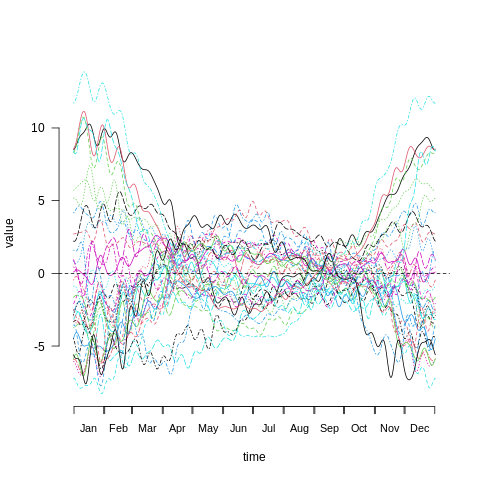

In [55]:
%%R
M_pen <- fourierpen(fdobj.res$basis, Lfdobj=0)
# suavizar un objeto fd
res.smooth <- smooth.basis(argvals = 1:365,
                           y = eval.fd(day.5, fdobj.res),
                           fdParobj = daybasis65)$fd

plot(res.smooth)

# Fit spherical model to the estimated trace-variogram by OLS
*nugget* : $\hat{\tau} = 0$, *partial sill* : $\hat{\sigma}^2 = 8306$ y *range* : $\hat{\phi} = 1778$

**Observación: al ajustar el modelo esférico al semivariograma empírico con los residuales suavizados de la regresión funcional usando coordenadas planas (en metros), las estimaciones son $\hat{\phi} = 24542$ y $\hat{\sigma}^2 = 2396$ se alejan de los valores estimados $\sigma^2 = 7769$ y $\phi = 2184$.**

In [56]:
%%R
# https://epsg.io/?q=Canada
# NAD 1983 Albers Canada
# Data source: ESRI
# Information source: ESRI
# Description: NAD 1983 Albers Canada

canada.CRS <- CRS(SRS_string="ESRI:102001")

CanadianWeather_planar = coords_

for(i in 1:nrow(coords_)){
  CanadianWeather_planar[i,] = coords_[i,] %>%
    #SpatialPoints(proj4string = CRS("+init=epsg:4326")) %>%
    #spTransform(canada.CRS) %>% st_as_sf() %>%
    st_as_sf(.,coords=c("W.longitude", "N.latitude"), crs = 4326) %>%
    #st_transform(crs = convertlatlong2UTM(.)) #%>%
    st_transform(crs = canada.CRS) %>%
    st_coordinates()
}

head(CanadianWeather_planar)

            W.longitude N.latitude
St. Johns       3087422  1838955.2
Halifax         2538286  1105840.4
Sydney          2672770  1394757.4
Yarmouth        2384287   919627.3
Charlottvl      1311128   422827.0
Fredericton     2263325  1114273.2


In [57]:
%%R
Eu_d = as.matrix(dist(CanadianWeather_planar, method = "euclidean"))
dist_ = data.frame(dist_km = Eu_d/1000) # 1M de distancias
Eu_d[Eu_d == 0] <- NA

#min(Eu_d, na.rm = TRUE)# 5486.667m -> 5.4 Km # CHIRPS: 5433.6 -> 5.4 Km
#max(Eu_d, na.rm = TRUE) # 1783762m -> 1783.7 Km # CHIRPS: 1845830 -> 1845 Km

for(i in 1:nrow(Eu_d)){
  for(j in 1:ncol(Eu_d)){
    if(i> j){Eu_d[i,j] <- Eu_d[i,j]}else{Eu_d[i,j] <- NA}
  }
}

dist_sttns = data.frame(dist_km = as.vector(Eu_d)/1000) # 1M de distancias

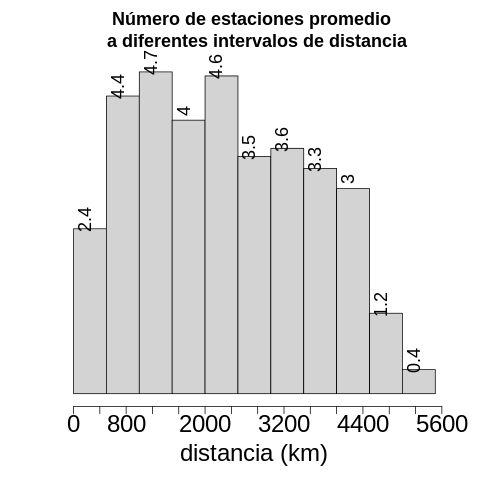

In [58]:
%%R
# [GRÁFICO] Número promedio de estaciones en un intervalo de distancia
# Interpretación: en promedio una sttn tiene 18-19 sttns a <50km
hist_ = hist(dist_sttns$dist_km, #breaks = seq(0,5900,400),
             xlab = "", ylab= "", main = "",
             axes = FALSE)
axis(side = 1, at = seq(0,5900,400), cex.axis = 2)
title(main = 'Número de estaciones promedio \n a diferentes intervalos de distancia',
      xlab = 'distancia (km)', cex.lab = 2, cex.main = 1.5)
text(x = hist_$mids + 1.5e1, y = hist_$counts +0.5 ,
     labels = round((hist_$counts)/(34/2),1),
     pos = 3, # Position above bars
     cex =1.5,
     srt = 90,  # Rotate text 90 degrees
     adj = 0.5, # Center alignment
     xpd = TRUE # Allow drawing outside plot region if needed
)

In [59]:
%%R
# l2.norm: Calculates L2 norm among functions
L2norm = l2.norm(s = ncol(fdobj.res$coefs), datafd = res.smooth, M = M_pen)

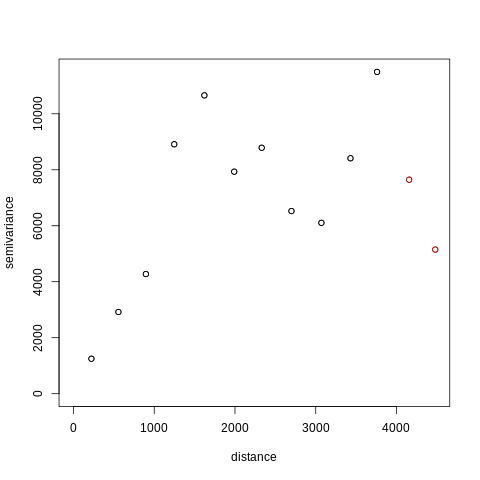

In [163]:
%%R
dista = max(dist(CanadianWeather_planar))*0.9 # 4720003m -> 4720 Km
tracev2bin = trace.variog(CanadianWeather_planar/1000, L2norm, bin=TRUE, max.dist=dista/1000)
# los puntos en rojo indican un comportamiento atípico para una función de semivarianze (la cual es creciente)
# por lo cual se restringe el dominio
plot(tracev2bin)
points(tracev2bin$u, tracev2bin$v, col = ifelse(tracev2bin$u > 4100, 'red', 'black'))

In [93]:
%%R
# Coord planas: Compute empirical Variograms for function-value data
dista = max(dist(CanadianWeather_planar))*0.8 # 4195558m -> 4195 Km
#tracev = trace.variog(CanadianWeather_planar, L2norm, bin=FALSE, max.dist=dista)

# ajusta el semivariograma empirico convirtiendo coordenadas de metros a Km
tracev2 = trace.variog(CanadianWeather_planar/1000, L2norm, bin=FALSE, max.dist=dista/1000)

fit_spherical2 = fit.tracevariog(emp.trace.vari = tracev2,
                                 models = c("spherical","exponential","gaussian","matern"),
                                 sigma2.0=quantile(tracev2$v, 0.75), # initial values
                                 phi.0=quantile(tracev2$Eu.d, 0.75), # initial values
                                 fix.nugget=FALSE, fix.kappa=FALSE,
                                 max.dist.variogram=dista/1000
                                )

print(fit_spherical2$best$cov.model)
print(paste0('variofit: minimised sum of squares (errors) = ',fit_spherical2$best$value))
print(paste0('nugget = ', fit_spherical2$best$nugget))
fit_spherical2$best$cov.pars

[1] "gaussian"
[1] "variofit: minimised sum of squares (errors) = 29030874281.7584"
[1] "nugget = 73.425757717952"
[1] 8604.0205  875.1711


In [94]:
%%R
fit_spherical2 = fit.tracevariog(emp.trace.vari = tracev2,
                                 #models = c("spherical","exponential","gaussian","matern"),
                                 models = "spherical",
                                 sigma2.0=quantile(tracev2$v, 0.75), # initial values
                                 phi.0=quantile(tracev2$Eu.d, 0.75), # initial values
                                 fix.nugget=FALSE, fix.kappa=FALSE,
                                 max.dist.variogram=dista/1000
                                )

print(fit_spherical2$best$cov.model)
print(paste0('variofit: minimised sum of squares (errors) = ',fit_spherical2$best$value))
print(paste0('nugget = ', fit_spherical2$best$nugget))
fit_spherical2$best$cov.pars

[1] "spherical"
[1] "variofit: minimised sum of squares (errors) = 29060413760.9983"
[1] "nugget = 0"
[1] 8594.441 1827.744


In [96]:
%%R
sigma2_ini = seq(max(tracev2$v)*0.3, quantile(tracev2$v, 0.9), length.out = 10)
phi_ini = seq(quantile(tracev2$Eu.d, 0.25), quantile(tracev2$Eu.d, 0.9), length.out = 10)
c(length(sigma2_ini), length(phi_ini))
length(rep(0, length(phi_ini)))
fit_bin = data.frame(sigma2_ini = sigma2_ini, phi_ini = phi_ini,
                     nugget = rep(0, length(phi_ini)),
                     sigma2 = rep(0, length(phi_ini)),
                     phi = rep(0, length(phi_ini)),
                     SSE = rep(0, length(phi_ini)))
fit_bin

   sigma2_ini  phi_ini nugget sigma2 phi SSE
1    12750.58 1121.858      0      0   0   0
2    13313.09 1457.056      0      0   0   0
3    13875.60 1792.255      0      0   0   0
4    14438.12 2127.453      0      0   0   0
5    15000.63 2462.651      0      0   0   0
6    15563.14 2797.849      0      0   0   0
7    16125.65 3133.047      0      0   0   0
8    16688.16 3468.246      0      0   0   0
9    17250.67 3803.444      0      0   0   0
10   17813.18 4138.642      0      0   0   0


In [97]:
%%R
# !!!la estimación de parámetros converge a los mismos valores iniciales
for(i in 1:10){
    fit_spherical2bin = fit.tracevariog(emp.trace.vari = tracev2bin,
                                        models = "spherical",
                                        sigma2.0=sigma2_ini[i], # initial values
                                        phi.0=phi_ini[i], # initial values
                                        fix.nugget=FALSE, fix.kappa=FALSE,
                                        max.dist.variogram=dista/1000
                                        )

    fit_bin$nugget[i] = fit_spherical2bin$best$nugget
    fit_bin$sigma2[i] = fit_spherical2bin$best$cov.pars[1]
    fit_bin$phi[i] = fit_spherical2bin$best$cov.pars[2]
    fit_bin$SSE[i] = fit_spherical2$best$value
}
fit_bin

   sigma2_ini  phi_ini nugget   sigma2      phi         SSE
1    12750.58 1121.858      0 12750.58 1121.858 29060413761
2    13313.09 1457.056      0 13313.09 1457.056 29060413761
3    13875.60 1792.255      0 13875.60 1792.255 29060413761
4    14438.12 2127.453      0 14438.12 2127.453 29060413761
5    15000.63 2462.651      0 15000.63 2462.651 29060413761
6    15563.14 2797.849      0 15563.14 2797.849 29060413761
7    16125.65 3133.047      0 16125.65 3133.047 29060413761
8    16688.16 3468.246      0 16688.16 3468.246 29060413761
9    17250.67 3803.444      0 17250.67 3803.444 29060413761
10   17813.18 4138.642      0 17813.18 4138.642 29060413761


In [98]:
%%R
print(fit_spherical2$fitted[[1]]$cov.model)
print(paste0('variofit: minimised sum of squares (errors) = ',
             fit_spherical2$fitted[[1]]$value))
tau = fit_spherical2$fitted[[1]]$nugget
sigmasq  = fit_spherical2$fitted[[1]]$cov.pars[1]
phi  = fit_spherical2$fitted[[1]]$cov.pars[2]
print(paste0('nugget = ', tau , ', partial sill = ',
             round(sigmasq) , ', range = ', round(phi)))

[1] "spherical"
[1] "variofit: minimised sum of squares (errors) = 29060413760.9983"
[1] "nugget = 0, partial sill = 8594, range = 1828"


(Cap 4.3) Schabenberger, O., & Gotway, C.A. (2005). Statistical Methods for Spatial Data Analysis (1st ed.). Chapman and Hall/CRC.

$\gamma(h) = \sigma^2 \Big( \frac{3}{2} \frac{h}{\phi} - \frac{1}{2} \big(\frac{h}{\phi}\big)^3 \Big)$

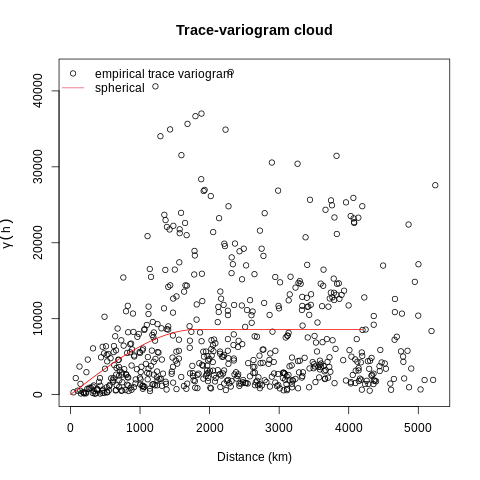

In [117]:
%%R
Gamma_h = (fit_spherical2$fitted[[1]]$nugget + fit_spherical2$fitted[[1]]$cov.pars[1]) -
    cov.spatial(1:h_max, cov.model = fit_spherical2$fitted[[1]]$cov.model,
                cov.pars = c(fit_spherical2$fitted[[1]]$cov.pars[1],
                             fit_spherical2$fitted[[1]]$cov.pars[2]))
dista2 = max(dist(CanadianWeather_planar))*0.8
h_max = as.integer(dista2/1000)

plot(tracev2$u, tracev2$v, xlab = 'Distance (km)',
     ylab = expression(gamma(h) ), main = 'Trace-variogram cloud') # gráfico del semivargiograma empirico
lines(1:h_max, Gamma_h, col = 'red')
legend("topleft", legend=c("empirical trace variogram","spherical"),
       pch = c(1, NA), lty = c(NA, 1), col = c(1,2), pt.cex = 1, bty = "n")

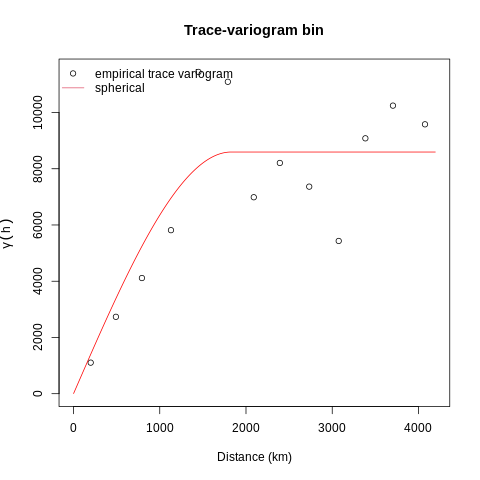

In [116]:
%%R
tracev2bin = trace.variog(CanadianWeather_planar/1000, L2norm, bin=TRUE, max.dist=dista2/1000)

plot(tracev2bin, xlab = 'Distance (km)',
     ylab = expression(gamma(h) ), main = 'Trace-variogram bin',
     xlim = c(0, h_max))
lines(1:h_max, Gamma_h, col = 'red')
legend("topleft", legend=c("empirical trace variogram","spherical"),
       pch = c(1, NA), lty = c(NA, 1), col = c(1,2), pt.cex = 1, bty = "n")

# Fig. 6. Hierarchical clustering of temperature curves recorded at 35 weather stations of Canada.

In [122]:
%%R
L2norm_ = l2.norm(s = ncol(Temp.fd$coefs), datafd = Temp.fd, M = M_pen)

In [123]:
%%R
sqrt_L2 = sqrt(L2norm_)
row.names(sqrt_L2) = CanadianWeather$place
hc_L2 = hclust(as.dist(sqrt_L2), method = "complete", members = NULL)

In [124]:
%%R
dend_data_L2 <- dendro_data(hc_L2, type = "rectangle")
h_cut_L2 <- hc_L2$height[nrow(sqrt_L2) - 9] + 1e01

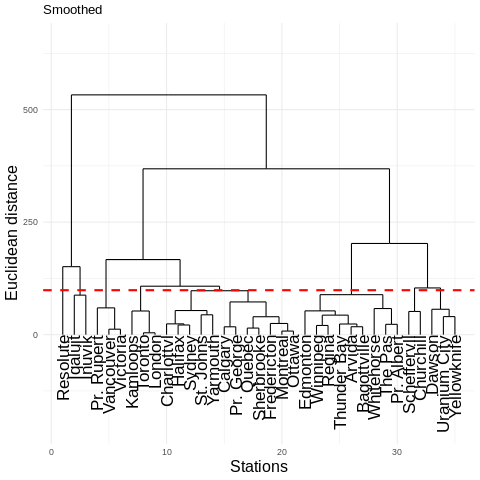

In [125]:
%%R
ggplot() +
  geom_segment(data = dend_data_L2$segments,
               aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_text(data = dend_data_L2$labels,
            aes(x = x, y = y, label = label),
            hjust = 1, angle = 90, size = 6) +
  geom_hline(yintercept = h_cut_L2,
             color = "red",
             linewidth = 1,
             linetype = "dashed") +
  coord_cartesian(ylim = c(-2e02, 6.5e02))+
  theme_minimal() +
  labs(title = "Smoothed",
       y = "Euclidean distance", x = "Stations")+
  theme(axis.title = element_text(size = 16))

In [126]:
%%R
memb_L2 <- cutree(hc_L2, k = 9)
coords_L2 <- mutate(coords_, clust_L2 = memb_L2,
                    clust_L2_paper = case_when(
                      clust_L2 == 1 ~ 5,
                      clust_L2 == 2 ~ 6,
                      clust_L2 == 3 ~ 8,
                      clust_L2 == 4 ~ 7,
                      clust_L2 == 5 ~ 4,
                      clust_L2 == 6 ~ 9,
                      clust_L2 == 7 ~ 3,
                      clust_L2 == 8 ~ 2,
                      clust_L2 == 9 ~ 1,
                      TRUE ~ NA_real_))

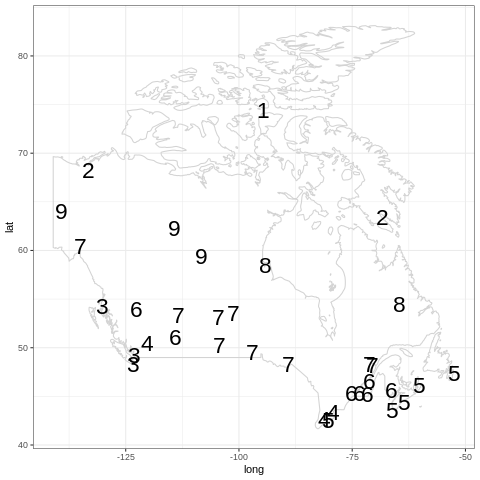

In [127]:
%%R
ggplot() +
  geom_polygon(data = canada, aes(x = long, y = lat, group = group),
               color = "lightgray", fill = NA) +
  geom_text(data = coords_L2,
            aes(x = W.longitude, y = N.latitude, label = clust_L2_paper), size = 8)+
  theme_bw()

# weighting dissimilarity matrix by the trace-variogram

In [144]:
%%R
semivariog_sph = function(tau2, sigma2, phi, model, hdist){
    Gamma_h = ifelse(hdist <= phi,
                     (tau2 + sigma2) - cov.spatial(h_dist, cov.model = model,
                                                   cov.pars = c(sigma2, phi)) ,
                     tau2+ sigma2)
  return(Gamma_h)
}

In [145]:
%%R
h_dist = st_distance(Canada_weather)
h_dist = set_units(h_dist, "km") # convierte a km
h_dist = matrix(as.numeric(h_dist), nr = nrow(h_dist), ncol = ncol(h_dist))

#Gamma_h = trace_variog(7769, 2184, h_dist)#/7769 # params paper
Gamma_h = semivariog_sph(tau2 = 0, sigma2 = 7769, phi = 2184,
                         model = 'sph', h_dist)
cols_ = seq(ncol(h_dist)-6, ncol(h_dist))
print(tail(h_dist[,cols_]))
tail(Gamma_h[,cols_])

           [,1]      [,2]      [,3]     [,4]     [,5]      [,6]     [,7]
[30,]  751.7973    0.0000  456.8517 1123.533 3348.037  873.4399 2243.817
[31,] 1208.4881  456.8517    0.0000 1264.141 3310.153  538.6660 2030.745
[32,] 1290.5851 1123.5329 1264.1415    0.000 2283.600 1102.0612 1555.578
[33,] 3552.0459 3348.0371 3310.1533 2283.600    0.000 2862.3687 1582.092
[34,] 1571.7553  873.4399  538.6660 1102.061 2862.369    0.0000 1503.194
[35,] 2740.4890 2243.8173 2030.7447 1555.578 1582.092 1503.1939    0.000
          [,1]     [,2]     [,3]     [,4]     [,5]     [,6]     [,7]
[30,] 3853.034    0.000 2402.138 5466.152 7769.000 4412.075 7769.000
[31,] 5790.194 2402.138    0.000 5991.978 7769.000 2815.960 7712.959
[32,] 6084.808 5466.152 5991.978    0.000 7769.000 5381.327 6896.704
[33,] 7769.000 7769.000 7769.000 7769.000    0.000 7769.000 6965.175
[34,] 6938.775 4412.075 2815.960 5381.327 7769.000    0.000 6754.270
[35,] 7769.000 7769.000 7712.959 6896.704 6965.175 6754.270    0.000


$d_ij^w = d_ij * \gamma(h) $, donde rezago espacial $h = dist(x_i, x_j)$ con $x_i = (lat_i, lon_i)$ y $dist$: distancia euclideana

In [146]:
%%R
wtv = sqrt(L2norm_)*Gamma_h
wtv_ = wtv/max(wtv)*99 # re-escala la longitud de height a 0-100
row.names(wtv_) = CanadianWeather$place
hc_wtv <- hclust(as.dist(wtv_), method = "complete", members = NULL)

In [147]:
%%R
dend_data_wtv <- dendro_data(hc_wtv, type = "rectangle")
h_cut_wtv <- hc_wtv$height[nrow(wtv_) - 9] #+ 1e01

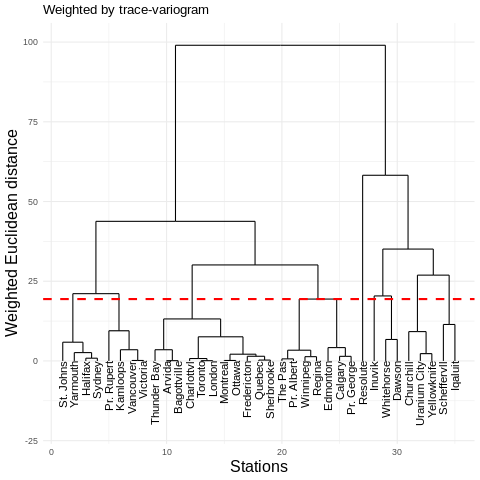

In [148]:
%%R
ggplot() +
  geom_segment(data = dend_data_wtv$segments,
               aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_text(data = dend_data_wtv$labels,
            aes(x = x, y = y, label = label),
            hjust = 1, angle = 90, size = 4) +
  geom_hline(yintercept = h_cut_wtv,
             color = "red",
             linewidth = 1,
             linetype = "dashed") +
  coord_cartesian(ylim = c(-2e01, 1e02))+
  theme_minimal() +
  labs(title = "Weighted by trace-variogram",
       y = "Weighted Euclidean distance", x = "Stations")+
  theme(axis.title = element_text(size = 16))

In [156]:
%%R
memb_wtv <- cutree(hc_wtv, k = 9)
coords_wtv <- mutate(coords_, clust_wtv = memb_wtv,
                     place = CanadianWeather$place,
                     clust_wtv_paper = case_when(
                         clust_wtv == 1 ~ 3,
                         clust_wtv == 2 ~ 5,
                         clust_wtv == 3 ~ 7,
                         clust_wtv == 4 ~ 2,
                         clust_wtv == 5 ~ 8,
                         clust_wtv == 6 ~ 1,
                         clust_wtv == 7 ~ 9,
                         clust_wtv == 8 ~ 4,
                         clust_wtv == 9 ~ 6,
                         TRUE ~ NA_real_)
                         )

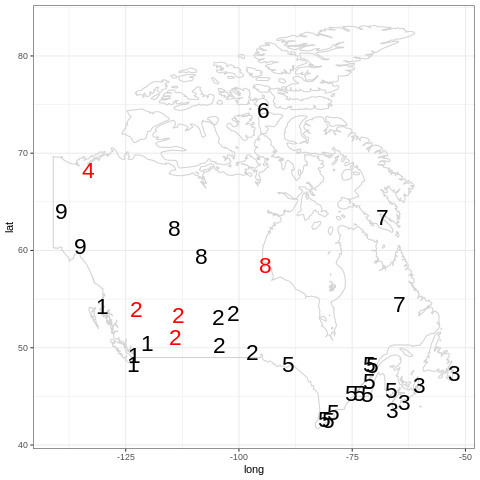

In [159]:
%%R
ggplot() +
  geom_polygon(data = canada, aes(x = long, y = lat, group = group),
               color = "lightgray", fill = NA) +
  geom_text(data = coords_wtv,
            aes(x = W.longitude, y = N.latitude,
                #label = clust_wtv), size = 8,
                label = clust_wtv_paper), size = 8,
            color = ifelse(coords_wtv$place %in% c("Calgary", "Edmonton", "Inuvik", "Pr. George", "Churchill"),
                           "red", "black"))+
  theme_bw()

## params fda::CanadianWeather

In [165]:
%%R
# "nugget = 0, partial sill = 8594, range = 1828"
Gamma_h2 = semivariog_sph(tau2 = tau, sigma2 = sigmasq, phi = phi,
                         model = 'sph', h_dist)
wtv2 = sqrt(L2norm_)*Gamma_h2 # params fda::CanadianWeather
wtv_2 = wtv2/max(wtv2)*99 # re-escala la longitud de height a 0-100
row.names(wtv_2) = CanadianWeather$place
hc_wtv2 <- hclust(as.dist(wtv_2), method = "complete", members = NULL)

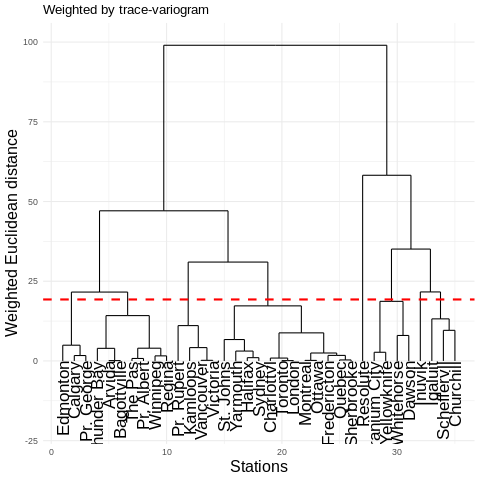

In [166]:
%%R
dend_data_wtv2 <- dendro_data(hc_wtv2, type = "rectangle")
h_cut_wtv2 <- hc_wtv2$height[nrow(wtv_2) - 9] + 2

ggplot() +
  geom_segment(data = dend_data_wtv2$segments,
               aes(x = x, y = y, xend = xend, yend = yend)) +
  geom_text(data = dend_data_wtv2$labels,
            aes(x = x, y = y, label = label),
            hjust = 1, angle = 90, size = 6) +
  geom_hline(yintercept = h_cut_wtv2,
             color = "red",
             linewidth = 1,
             linetype = "dashed") +
  coord_cartesian(ylim = c(-2e01, 1e02))+
  theme_minimal() +
  labs(title = "Weighted by trace-variogram",
       y = "Weighted Euclidean distance", x = "Stations")+
  theme(axis.title = element_text(size = 16))

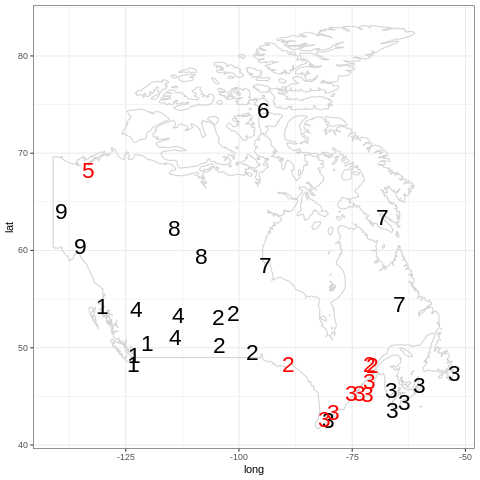

In [174]:
%%R
memb_wtv2 <- cutree(hc_wtv2, k = 9)
coords_wtv2  = mutate(coords_, place = CanadianWeather$place,
                      clust_wtv2 = memb_wtv2,
                      clust_wtv_paper = case_when(
                        clust_wtv2 == 1 ~ 3,
                        clust_wtv2 == 2 ~ 7,
                        clust_wtv2 == 3 ~ 2,
                        clust_wtv2 == 4 ~ 8,
                        clust_wtv2 == 5 ~ 4,
                        clust_wtv2 == 6 ~ 1,
                        clust_wtv2 == 7 ~ 9,
                        clust_wtv2 == 8 ~ 5,
                        clust_wtv2 == 9 ~ 6,
                        TRUE ~ NA_real_)
                        )

ggplot() +
  geom_polygon(data = canada, aes(x = long, y = lat, group = group),
               color = "lightgray", fill = NA) +
  geom_text(data = coords_wtv2,
            aes(x = W.longitude, y = N.latitude, label = clust_wtv_paper),
            #aes(x = W.longitude, y = N.latitude, label = clust_wtv2),
            color = ifelse(coords_wtv2$place %in% c("Arvida", "Bagottville", "Inuvik", "Thunder Bay",
                                                    "London", "Toronto", "Ottawa", "Montreal", "Quebec", "Sherbrooke"),
                           "red", "black"), size = 8)+
  theme_bw()

# Cluster quality measure: Silhouette

In [175]:
%%R
k_range <- 2:25

clusters_wtv <- lapply(k_range, function(k) cutree(hc_wtv, k = k))
names(clusters_wtv) <- paste0("k_", k_range)

sil_width_wtv <- sapply(clusters_wtv, function(cl) {
  mean(silhouette(x = cl, dist = as.dist(wtv))[, 3])
})

clusters_wtv2 <- lapply(k_range, function(k) cutree(hc_wtv2, k = k))
names(clusters_wtv2) <- paste0("k_", k_range)

sil_width_wtv2 <- sapply(clusters_wtv2, function(cl) {
  mean(silhouette(x = cl, dist = as.dist(wtv2))[, 3])
})

clust_qidx <- data.frame(
  n_clust = k_range,
  Silhouette = sil_width_wtv,
  Silhouette2 = sil_width_wtv2)

head(clust_qidx)

    n_clust Silhouette Silhouette2
k_2       2  0.6112105   0.6044139
k_3       3  0.5543556   0.5521948
k_4       4  0.3817894   0.3612872
k_5       5  0.3577975   0.3406892
k_6       6  0.3793812   0.4302757
k_7       7  0.3723254   0.4141166


In [176]:
%%R
my_theme_sil <- function() {
  theme(
    strip.text = element_text(size = 24, face = "bold"),
    axis.text = element_text(size = 24),
    axis.title = element_text(size = 24),
    axis.text.x = element_text(size = 12),
    axis.text.y = element_text(size = 12),
    panel.grid.minor.x = element_blank(),
    panel.grid.minor.y = element_blank(),
    panel.grid.major.x = element_line(color = "lightgrey", size = 0.25)
  )
}

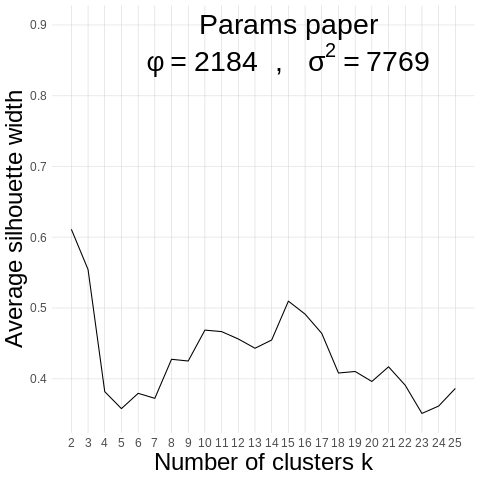

In [177]:
%%R
ggplot(clust_qidx)+
  geom_line(aes(x = n_clust, y = Silhouette))+
  scale_x_continuous(breaks = seq(2, 25, 1)) +
  theme_minimal() +
  labs(y = 'Average silhouette width', x = 'Number of clusters k')+
  my_theme_sil()+
  annotate(geom = "text", x = 15, y = 0.9,
           label = "Params paper",
           size = 10) +
  annotate(geom = "text", x = 15, y = 0.85,
           label = as.character(expression(phi == 2184 ~ ', ' ~ sigma^2 == 7769)),
           parse = TRUE,
           size = 10)

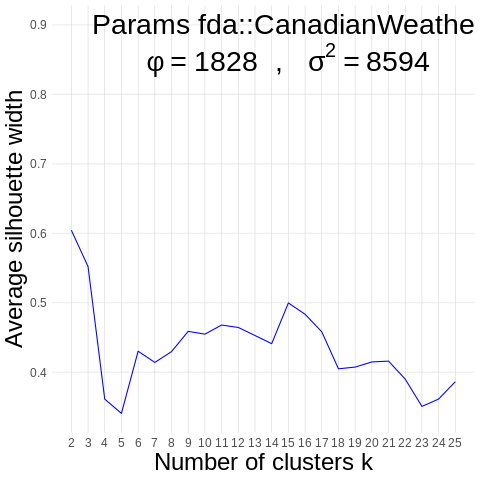

In [179]:
%%R
ggplot(clust_qidx)+
  geom_line(aes(x = n_clust, y = Silhouette2), color = 'blue')+
  scale_x_continuous(breaks = seq(2, 25, 1)) +
  theme_minimal() +
  labs(y = 'Average silhouette width', x = 'Number of clusters k')+
  my_theme_sil()+
  annotate(geom = "text", x = 15, y = 0.9,
           label = "Params fda::CanadianWeather",
           size = 10) +
  annotate(geom = "text", x = 15, y = 0.85,
           #label = as.character(expression(phi == 1778 ~ ', ' ~ sigma^2 == 8306)),
           label = as.character(expression(phi == 1828 ~ ', ' ~ sigma^2 == 8594)),
           parse = TRUE,
           size = 10)

# [Clustering the “Canadian temperature” data (Ramsey & Silverman): multivariate case](https://rpubs.com/stat17_hb/functional_data_clustering)

In [ ]:
%%R
basis <- create.fourier.basis(c(0, 365), nbasis=21, period=365)

daytempfd <- smooth.basis(day.5, CanadianWeather$dailyAv[,,"Temperature.C"], basis,
                          fdnames=list("Day", "Station", "Deg C"))$fd

dayprecfd <- smooth.basis(day.5, CanadianWeather$dailyAv[,,"Precipitation.mm"], basis,
                        fdnames=list("Day", "Station", "Mm"))$fd

In [ ]:
%%R
remotes::install_github("cran/funHDDC")
library(funHDDC)

── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp16KLEs/remotes4fa7a8cdf2d/cran-funHDDC-a5e9898/DESCRIPTION’ ... OK
* preparing ‘funHDDC’:
* checking DESCRIPTION meta-information ... OK
* checking vignette meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘funHDDC_2.3.1.tar.gz’



(as ‘lib’ is unspecified)

  method  from
  plot.fd fda 

Attaching package: ‘funHDDC’



    plot.fd




In [ ]:
%%R
res.multi <- funHDDC(list(daytempfd,dayprecfd), K=4)

      model K threshold complexity       BIC
1 AKJBKQKDK 4       0.2        466 -7,303.18

SELECTED: model  AKJBKQKDK  with  4  clusters.
Selection Criterion: BIC.


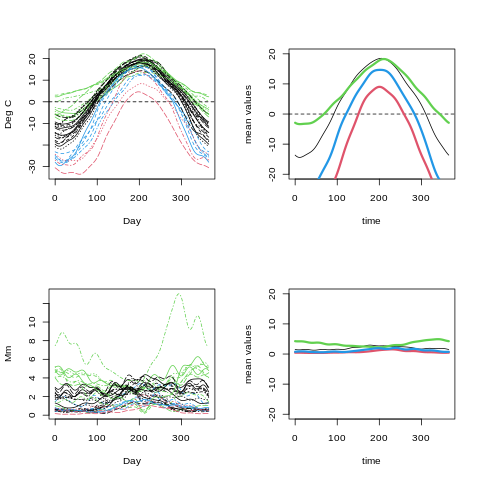

In [ ]:
%%R
## Graphical representation of groups mean curves
par(mfrow=c(2,2))

## Temperature
plot(daytempfd, col=res.multi$class, lwd=2, lty=1)
select1 <- fd(daytempfd$coefs[,which(res.multi$class==1)], daytempfd$basis)
select2 <- fd(daytempfd$coefs[,which(res.multi$class==2)], daytempfd$basis)
select3 <- fd(daytempfd$coefs[,which(res.multi$class==3)], daytempfd$basis)
select4 <- fd(daytempfd$coefs[,which(res.multi$class==4)], daytempfd$basis)

plot(mean.fd(select1),col=1, ylim=c(-20,20), lty=1, lwd=3)
lines(mean.fd(select2),col=2, lty=1,lwd=3)
lines(mean.fd(select3),col=3, lty=1,lwd=3)
lines(mean.fd(select4),col=4, lty=1,lwd=3)

## Precipitation
plot(dayprecfd, col=res.multi$class, lwd=2, lty=1)

select1b <- fd(dayprecfd$coefs[,which(res.multi$class==1)], dayprecfd$basis)
select2b <- fd(dayprecfd$coefs[,which(res.multi$class==2)], dayprecfd$basis)
select3b <- fd(dayprecfd$coefs[,which(res.multi$class==3)], dayprecfd$basis)
select4b <- fd(dayprecfd$coefs[,which(res.multi$class==4)], dayprecfd$basis)

plot(mean.fd(select1b),col=1, ylim=c(-20,20), lty=1, lwd=3)
lines(mean.fd(select2b),col=2, lty=1,lwd=3)
lines(mean.fd(select3b),col=3, lty=1,lwd=3)
lines(mean.fd(select4b),col=4, lty=1,lwd=3)

In [ ]:
%%R
colnames(daytempfd$coefs[,which(res.multi$class==1)])

 [1] "Fredericton" "Arvida"      "Bagottville" "Quebec"      "Sherbrooke" 
 [6] "Montreal"    "Ottawa"      "London"      "Thunder Bay" "Winnipeg"   
[11] "The Pas"     "Regina"      "Pr. Albert"  "Edmonton"    "Calgary"    
[16] "Pr. George"  "Whitehorse" 


In [ ]:
%%R
CanadianWeather$place

 [1] "St. Johns"    "Halifax"      "Sydney"       "Yarmouth"     "Charlottvl"  
 [6] "Fredericton"  "Scheffervll"  "Arvida"       "Bagottville"  "Quebec"      
[11] "Sherbrooke"   "Montreal"     "Ottawa"       "Toronto"      "London"      
[16] "Thunder Bay"  "Winnipeg"     "The Pas"      "Churchill"    "Regina"      
[21] "Pr. Albert"   "Uranium City" "Edmonton"     "Calgary"      "Kamloops"    
[26] "Vancouver"    "Victoria"     "Pr. George"   "Pr. Rupert"   "Whitehorse"  
[31] "Dawson"       "Yellowknife"  "Iqaluit"      "Inuvik"       "Resolute"    


In [ ]:
%%R
data.frame(list("place"=colnames(daytempfd$coefs), "class"=res.multi$class)) %>% filter(class ==1)

         place class
1  Fredericton     1
2       Arvida     1
3  Bagottville     1
4       Quebec     1
5   Sherbrooke     1
6     Montreal     1
7       Ottawa     1
8       London     1
9  Thunder Bay     1
10    Winnipeg     1
11     The Pas     1
12      Regina     1
13  Pr. Albert     1
14    Edmonton     1
15     Calgary     1
16  Pr. George     1
17  Whitehorse     1


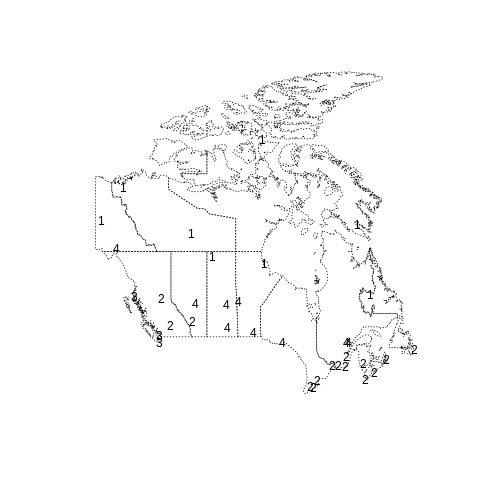

In [ ]:
%%R
plot(Canada$geometry, lty = 3)
plot(CanadianWeather.point, pch = as.character(res.multi$class), add = TRUE)